In [6]:
import os
import numpy as np

import _init_paths
import caffe
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
# display plots in this notebook
%matplotlib inline

from datasets.factory import get_imdb
from roi_data_layer.roidb import prepare_roidb
from fast_rcnn.bbox_transform import scale_bboxes
from fast_rcnn.bbox_transform import clip_boxes
from fast_rcnn.bbox_transform import find_valid_ref_bboxes
from fast_rcnn.bbox_transform import bbox_transform

In [2]:
# configure plotting
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
def xy2wh(bbox):
    x1 = int(bbox[0])
    y1 = int(bbox[1])
    x2 = int(bbox[2])
    y2 = int(bbox[3])
    w = x2 - x1 + 1
    h = y2 - y1 + 1
    return [x1, y1, w, h]

## Prepare roidb

In [4]:
imdb = get_imdb('ilsvrc_2013_val1')
imdb.set_proposal_method('slide')
prepare_roidb(imdb)
roidb = imdb.roidb

ilsvrc_2013_val1 slide roidb loaded from /home/kwang/Documents/ilsvrc/py-faster-rcnn/data/cache/ilsvrc_2013_val1_slide_top2000_roidb.pkl


## Load and Display Image

ILSVRC2012_val_00020457.JPEG
0 [ 0.  0.  0.  0.]
20 [ 0.07142857  2.44230769  1.49610923  1.84784894]
40 [-0.23856209 -0.14354067 -0.20212418 -0.23638878]
60 [-0.66883117  1.40298507  1.1776555   0.90125285]
80 [ 0.25       -0.15923567  0.32850407  0.04969967]
100 [-0.08581236 -0.08143322 -0.55847228 -0.62090227]
120 [-0.27922078  1.93269231  1.1776555   1.15470176]
140 [ 0.37878788  0.58015267  0.638659    0.23074815]
160 [ 0.62962963  1.37681159  1.53247687  0.87183897]
180 [-0.75        1.99        2.05572502  1.19392247]


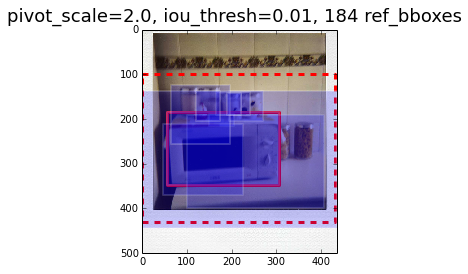

In [12]:
image_index = 150
pivot_scale = 2.0
iou_thresh = 0.01

im_path = roidb[image_index]['image']
im = mpimg.imread(im_path)
print os.path.basename(im_path)

# display image
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.imshow(im)

box_proposals = roidb[image_index]['boxes']
num_bbox = box_proposals.shape[0]

for i in xrange(1):
    # original pivot bbox
    pivot_bbox = box_proposals[i, :].astype(np.float32)
    # check pivot_bbox is np.float32 data type or not
    assert pivot_bbox.dtype == np.float32
    
    x1, y1, w, h = xy2wh(pivot_bbox)
    pivot_rect = patches.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=3)
    ax1.add_patch(pivot_rect)

    # scaled pivot bbox
    scaled_pivot_bbox = scale_bboxes(pivot_bbox[np.newaxis, :], pivot_scale)[0, :]
    scaled_pivot_bbox = clip_boxes(scaled_pivot_bbox[np.newaxis], im.shape)[0, :]
    x1, y1, w, h = xy2wh(scaled_pivot_bbox)
    scaled_rect = patches.Rectangle((x1, y1), w, h, fill=False, edgecolor='red', linewidth=3, linestyle='dashed')
    ax1.add_patch(scaled_rect)
        
    # find valid ref_bboxes about pivot_bbox
    ref_bboxes = find_valid_ref_bboxes(pivot_bbox, box_proposals, im.shape, pivot_scale, iou_thresh)
    num_ref_bbox = ref_bboxes.shape[0]

    for j in xrange(0, num_ref_bbox, 20):
        # ref bbox
        ref_bbox = ref_bboxes[j, :]
        x1, y1, w, h = xy2wh(ref_bbox)
        ref_rect = patches.Rectangle((x1, y1), w, h, edgecolor='white', linewidth=2, alpha=0.2)
        ax1.add_patch(ref_rect)
        target = bbox_transform(ref_bbox[np.newaxis, :], pivot_bbox[np.newaxis, :])[0, :]
        print '{} {}'.format(j, target)

    fig1.suptitle('pivot_scale={}, iou_thresh={}, {} ref_bboxes'.format(pivot_scale, iou_thresh, num_ref_bbox), fontsize=18)
    plt.show()